In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
training_data = pd.read_parquet('C:/Users/nguye/Downloads/BTCUSDT/')
labels = pd.read_parquet('C:/Users/nguye/Downloads/LABEL_BTCUSDT/')
labels.drop(columns="SYMBOL", inplace=True)
join_data = training_data.join(labels, how='left')
training_data.index = pd.to_datetime(training_data.index, unit='ms')
labels.index = pd.to_datetime(labels.index, unit='ms')

In [2]:
full_data = training_data.join(labels, how='left')
# labeled_data = training_data.join(labels, how='right')
labeled_data = training_data.join(labels)
labeled_data.dropna(inplace=True)


## Calculate R and V of data

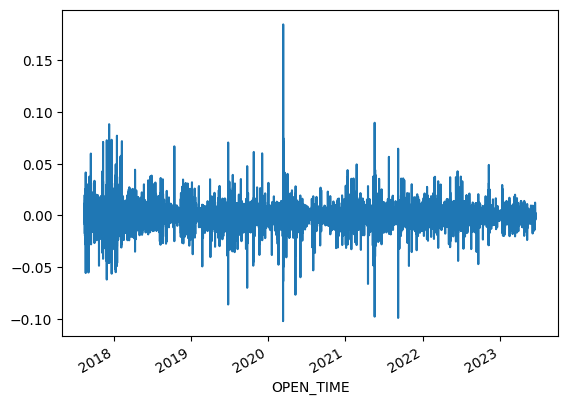

<Axes: xlabel='OPEN_TIME'>

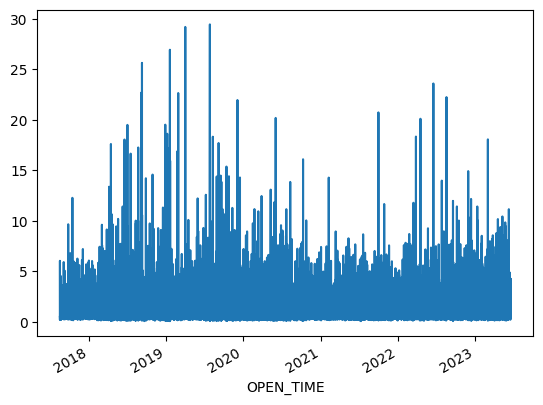

In [3]:
full_data['RETURN_RATE'] = (
    full_data['CLOSE'] - full_data['OPEN']) / full_data['OPEN']

std_backward = full_data['CLOSE'].rolling(19).std()
# rooling backward
std_forward = full_data['CLOSE'].rolling(19).std().shift(-6)
std_ratio = std_forward / std_backward

full_data['V'] = std_ratio

full_data['RETURN_RATE'].plot.line()
plt.show()
full_data['V'].plot.line()


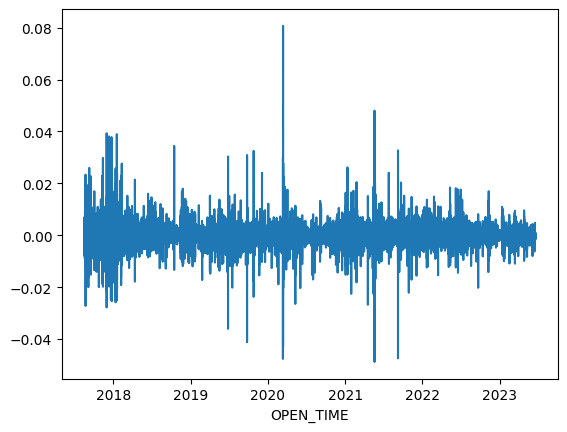

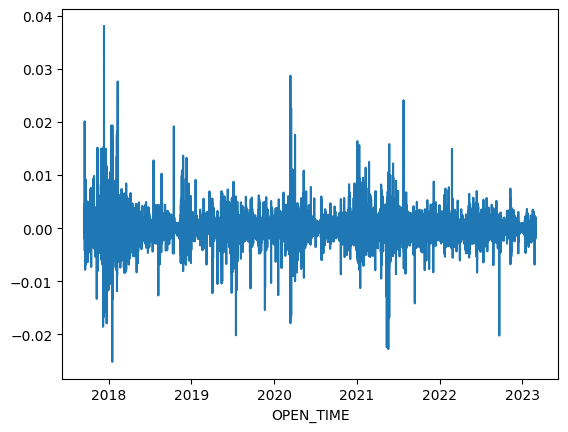

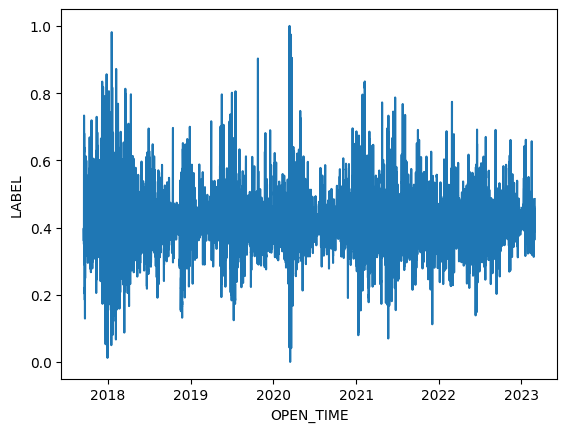

(612386,) (47662,)


In [4]:
y = full_data['RETURN_RATE'] / np.sqrt(full_data['V']) / 2


y_for_label = y.loc[labeled_data.index]
sns.lineplot(data=y)
plt.show()
sns.lineplot(data=y_for_label)
plt.show()
sns.lineplot(data=labeled_data['LABEL'])
plt.show()
print(y.shape, labeled_data['LABEL'].shape)


<Axes: xlabel='OPEN_TIME'>

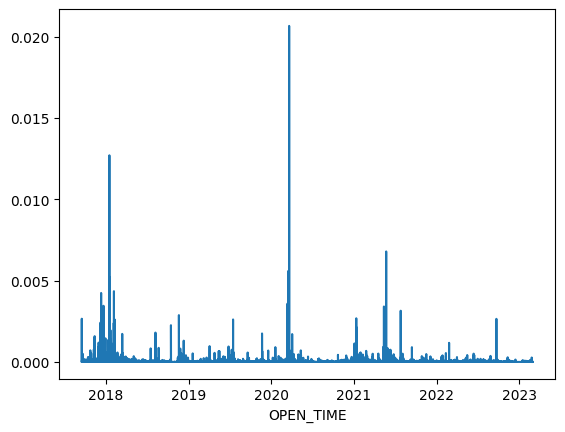

In [35]:
p_bm = (y_for_label**2) / (labeled_data['LABEL']**2)
sns.lineplot(data=p_bm)

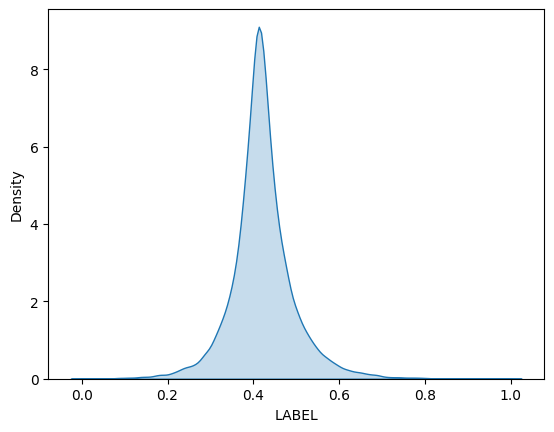

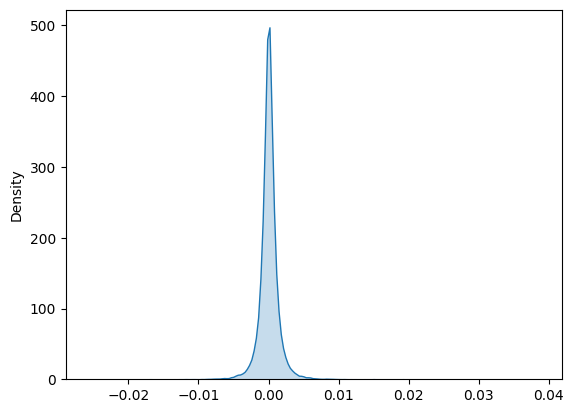

In [5]:
sns.kdeplot(data=labeled_data['LABEL'],fill=True)
# sns.kdeplot(y_for_label,fill=True)
# plt.legend(['LABEL', 'RETURN_RATE'])
# plt.xlim(-1, 1)
plt.show()
sns.kdeplot(y_for_label,fill=True)
plt.show()

In [6]:
labeled_data['LABEL'].describe()

count    47662.000000
mean         0.420557
std          0.074462
min          0.000000
25%          0.385336
50%          0.416168
75%          0.451782
max          1.000000
Name: LABEL, dtype: float64

25% of the data is:  0.38533571428261615
50% of the data is:  0.41616828940095507
75% of the data is:  0.45178177336857694


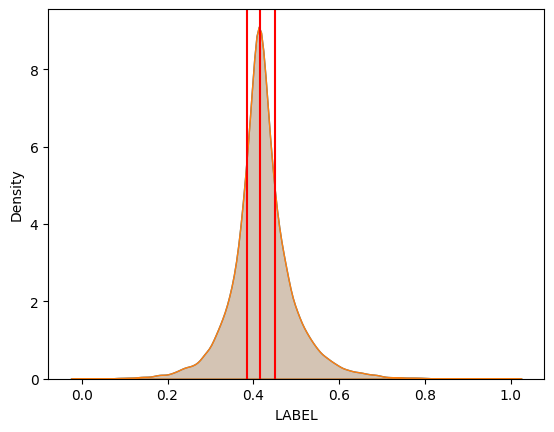

In [7]:
sns.kdeplot(data=labeled_data['LABEL'],fill=True)

print('25% of the data is: ', labeled_data['LABEL'].quantile(0.25))
print('50% of the data is: ', labeled_data['LABEL'].quantile(0.50))
print('75% of the data is: ', labeled_data['LABEL'].quantile(0.75))

# plot this quantile
sns.kdeplot(data=labeled_data['LABEL'],fill=True)
plt.axvline(labeled_data['LABEL'].quantile(0.25), color='red')
plt.axvline(labeled_data['LABEL'].quantile(0.50), color='red')
plt.axvline(labeled_data['LABEL'].quantile(0.75), color='red')
plt.show()


In [8]:
# p_bm = (predict_label**2) /((labeled_data['LABEL']) ** 2 + 1e-3)
# p_bm.describe()

In [9]:
# labels['2017-09-16 10:00:00']
valid_labels_index = labels.index.intersection(training_data.index)
training_data.loc[valid_labels_index].shape


(47662, 10)